In [32]:
import pandas as pd
import duckdb as db
import os

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Connected to database: ../../database/clinisys_all.duckdb
Database file exists: True

=== Available Schemas ===
          schema_name
0              bronze
1                gold
2                main
3              silver
4  information_schema
5                main
6          pg_catalog
7                main

=== Tables in Silver Schema (16 tables) ===
                           table_name  table_type
0         view_congelamentos_embrioes  BASE TABLE
1           view_congelamentos_ovulos  BASE TABLE
2      view_descongelamentos_embrioes  BASE TABLE
3        view_descongelamentos_ovulos  BASE TABLE
4            view_embrioes_congelados  BASE TABLE
5   view_extrato_atendimentos_central  BASE TABLE
6                   view_medicamentos  BASE TABLE
7       view_medicamentos_prescricoes  BASE TABLE
8                        view_medicos  BASE TABLE
9               view_micromanipulacao  BASE TABLE
10      view_micromanipulacao_oocitos  BASE TABLE
11                    view_orcamentos  BASE T
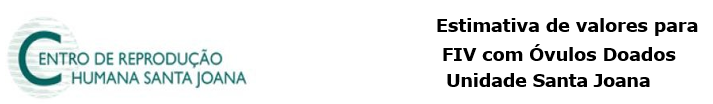
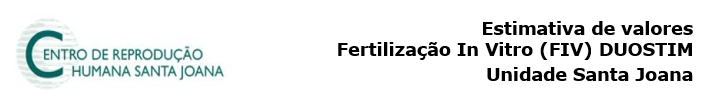
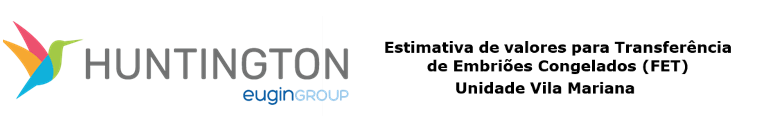
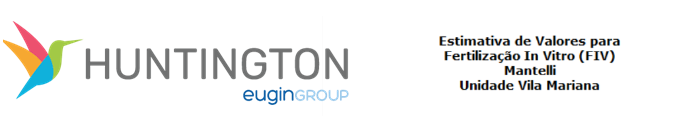
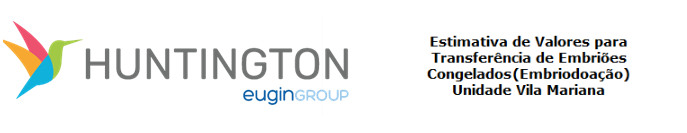

In [33]:
# Connect to the clinisys_all database
path_to_db = '../../database/clinisys_all.duckdb'
conn = db.connect(path_to_db, read_only=True)

print(f"Connected to database: {path_to_db}")
print(f"Database file exists: {os.path.exists(path_to_db)}")

# List all schemas
schemas = conn.execute("SELECT schema_name FROM information_schema.schemata").fetchdf()
print("\n=== Available Schemas ===")
print(schemas)

# List all tables in silver schema
silver_tables = conn.execute("""
    SELECT table_name, table_type 
    FROM information_schema.tables 
    WHERE table_schema = 'silver'
    ORDER BY table_name
""").fetchdf()

print(f"\n=== Tables in Silver Schema ({len(silver_tables)} tables) ===")
print(silver_tables)

# Explore each table in silver schema
print("\n" + "="*80)
print("EXPLORING SILVER SCHEMA TABLES")
print("="*80)

for idx, row in silver_tables.iterrows():
    table_name = row['table_name']
    table_type = row['table_type']
    
    print(f"\n{'='*60}")
    print(f"TABLE: {table_name} (Type: {table_type})")
    print(f"{'='*60}")
    
    try:
        # Get table schema
        schema_info = conn.execute(f"""
            SELECT column_name, data_type, is_nullable
            FROM information_schema.columns 
            WHERE table_schema = 'silver' AND table_name = '{table_name}'
            ORDER BY ordinal_position
        """).fetchdf()
        
        print(f"\nSchema ({len(schema_info)} columns):")
        # print(schema_info.to_string(index=False))
        
        # Get row count
        count_result = conn.execute(f"SELECT COUNT(*) as row_count FROM silver.{table_name}").fetchdf()
        row_count = count_result['row_count'].iloc[0]
        print(f"\nTotal rows: {row_count:,}")
        
        # Get sample data (first 10 rows)
        if row_count > 0:
            sample_data = conn.execute(f"SELECT * FROM silver.{table_name} LIMIT 10").fetchdf()
            print(f"\nSample data (first 10 rows):")
            print(sample_data.to_string(index=False))
            
            # Show data types and null counts
            print(f"\nData info:")
            print(f"Shape: {sample_data.shape}")
            print(f"Memory usage: {sample_data.memory_usage(deep=True).sum() / 1024:.2f} KB")
            
            # Show null counts for each column
            null_counts = sample_data.isnull().sum()
            if null_counts.sum() > 0:
                print(f"\nNull counts in sample:")
                for col, null_count in null_counts.items():
                    if null_count > 0:
                        print(f"  {col}: {null_count}")
        else:
            print("\nTable is empty - no sample data to show")
            
    except Exception as e:
        print(f"Error exploring table {table_name}: {str(e)}")
    
    print(f"\n{'-'*60}")

# Close connection
conn.close()
print(f"\n{'='*80}")
print("EXPLORATION COMPLETE")
print(f"{'='*80}")

In [34]:
#!/usr/bin/env python3
"""
Extract Prontuario Data - Modular Functions
Extract data for a specific prontuario from finops tables with individual functions for each table.
"""

import pandas as pd
import duckdb as db
import os

def get_database_connection():
    """
    Create and return a connection to the clinisys_all database
    
    Returns:
        duckdb.DuckDBPyConnection: Database connection
    """
    path_to_db = '../../database/clinisys_all.duckdb'
    conn = db.connect(path_to_db, read_only=True)
    
    print(f"Connected to database: {path_to_db}")
    print(f"Database file exists: {os.path.exists(path_to_db)}")
    
    return conn

def extract_orcamentos_data(conn, target_prontuario):
    """
    Extract orcamentos data for a specific prontuario
    
    Args:
        conn: Database connection
        target_prontuario (int): The prontuario number to extract data for
        
    Returns:
        pd.DataFrame: DataFrame containing orcamentos data
    """
    print(f"\n2. EXTRACTING VIEW_ORCAMENTOS DATA")
    print("-" * 50)
    
    try:
        # Check schema first
        schema_orc = conn.execute("""
            SELECT column_name, data_type 
            FROM information_schema.columns 
            WHERE table_schema = 'silver' AND table_name = 'view_orcamentos'
            ORDER BY ordinal_position
        """).fetchdf()
        print(f"view_orcamentos columns: {list(schema_orc['column_name'])}")
        
        # Extract data
        orcamentos_df = conn.execute(f"""
            SELECT * FROM silver.view_orcamentos 
            WHERE prontuario = {target_prontuario}
            ORDER BY id DESC
        """).fetchdf()
        
        print(f"Found {len(orcamentos_df)} records in view_orcamentos")
        if len(orcamentos_df) > 0:
            print("Sample data:")
            print(orcamentos_df.head())
            print(f"Columns: {list(orcamentos_df.columns)}")
        else:
            print("No data found for this prontuario")
            
    except Exception as e:
        print(f"Error extracting orcamentos data: {str(e)}")
        orcamentos_df = pd.DataFrame()
    
    return orcamentos_df

def extract_extrato_atendimento_central_data(conn, target_prontuario):
    """
    Extract extrato_atendimento_central data for a specific prontuario
    
    Args:
        conn: Database connection
        target_prontuario (int): The prontuario number to extract data for
        
    Returns:
        pd.DataFrame: DataFrame containing extrato_atendimento_central data
    """
    print(f"\n3. EXTRACTING VIEW_EXTRATO_ATENDIMENTO_CENTRAL DATA")
    print("-" * 50)
    
    try:
        # Check schema first
        schema_eac = conn.execute("""
            SELECT column_name, data_type 
            FROM information_schema.columns 
            WHERE table_schema = 'silver' AND table_name = 'view_extrato_atendimentos_central'
            ORDER BY ordinal_position
        """).fetchdf()
        print(f"view_extrato_atendimento_central columns: {list(schema_eac['column_name'])}")
        
        # Extract data
        extrato_atendimento_central_df = conn.execute(f"""
            SELECT * FROM silver.view_extrato_atendimentos_central 
            WHERE prontuario = {target_prontuario}
            ORDER BY data DESC, inicio DESC
        """).fetchdf()
        
        print(f"Found {len(extrato_atendimento_central_df)} records in view_extrato_atendimento_central")
        if len(extrato_atendimento_central_df) > 0:
            print("Sample data:")
            print(extrato_atendimento_central_df.head())
            print(f"Columns: {list(extrato_atendimento_central_df.columns)}")
        else:
            print("No data found for this prontuario")
            
    except Exception as e:
        print(f"Error extracting extrato_atendimento_central data: {str(e)}")
        extrato_atendimento_central_df = pd.DataFrame()
    
    return extrato_atendimento_central_df

def extract_tratamentos_data(conn, target_prontuario):
    """
    Extract tratamentos data for a specific prontuario
    
    Args:
        conn: Database connection
        target_prontuario (int): The prontuario number to extract data for
        
    Returns:
        pd.DataFrame: DataFrame containing tratamentos data
    """
    print(f"\n4. EXTRACTING VIEW_TRATAMENTOS DATA")
    print("-" * 50)
    
    try:
        # Check schema first
        schema_trat = conn.execute("""
            SELECT column_name, data_type 
            FROM information_schema.columns 
            WHERE table_schema = 'silver' AND table_name = 'view_tratamentos'
            ORDER BY ordinal_position
        """).fetchdf()
        print(f"view_tratamentos columns: {list(schema_trat['column_name'])}")
        
        # Extract data
        tratamentos_df = conn.execute(f"""
            SELECT * FROM silver.view_tratamentos 
            WHERE prontuario = {target_prontuario}
            ORDER BY id DESC
        """).fetchdf()
        
        print(f"Found {len(tratamentos_df)} records in view_tratamentos")
        if len(tratamentos_df) > 0:
            print("Sample data:")
            print(tratamentos_df.head())
            print(f"Columns: {list(tratamentos_df.columns)}")
        else:
            print("No data found for this prontuario")
            
    except Exception as e:
        print(f"Error extracting tratamentos data: {str(e)}")
        tratamentos_df = pd.DataFrame()
    
    return tratamentos_df

def extract_congelamentos_embrioes_data(conn, target_prontuario):
    """
    Extract congelamentos_embrioes data for a specific prontuario
    
    Args:
        conn: Database connection
        target_prontuario (int): The prontuario number to extract data for
        
    Returns:
        pd.DataFrame: DataFrame containing congelamentos_embrioes data
    """
    print(f"\n5. EXTRACTING VIEW_CONGELAMENTOS_EMBRIOES DATA")
    print("-" * 50)
    
    try:
        # Check schema first
        schema_ce = conn.execute("""
            SELECT column_name, data_type 
            FROM information_schema.columns 
            WHERE table_schema = 'silver' AND table_name = 'view_congelamentos_embrioes'
            ORDER BY ordinal_position
        """).fetchdf()
        print(f"view_congelamentos_embrioes columns: {list(schema_ce['column_name'])}")
        
        # Extract data
        congelamentos_embrioes_df = conn.execute(f"""
            SELECT * FROM silver.view_congelamentos_embrioes 
            WHERE prontuario = {target_prontuario}
            ORDER BY id DESC
        """).fetchdf()
        
        print(f"Found {len(congelamentos_embrioes_df)} records in view_congelamentos_embrioes")
        if len(congelamentos_embrioes_df) > 0:
            print("Sample data:")
            print(congelamentos_embrioes_df.head())
            print(f"Columns: {list(congelamentos_embrioes_df.columns)}")
        else:
            print("No data found for this prontuario")
            
    except Exception as e:
        print(f"Error extracting congelamentos_embrioes data: {str(e)}")
        congelamentos_embrioes_df = pd.DataFrame()
    
    return congelamentos_embrioes_df

def extract_congelamentos_ovulos_data(conn, target_prontuario):
    """
    Extract congelamentos_ovulos data for a specific prontuario
    
    Args:
        conn: Database connection
        target_prontuario (int): The prontuario number to extract data for
        
    Returns:
        pd.DataFrame: DataFrame containing congelamentos_ovulos data
    """
    print(f"\n6. EXTRACTING VIEW_CONGELAMENTOS_OVULOS DATA")
    print("-" * 50)
    
    try:
        # Check schema first
        schema_co = conn.execute("""
            SELECT column_name, data_type 
            FROM information_schema.columns 
            WHERE table_schema = 'silver' AND table_name = 'view_congelamentos_ovulos'
            ORDER BY ordinal_position
        """).fetchdf()
        print(f"view_congelamentos_ovulos columns: {list(schema_co['column_name'])}")
        
        # Extract data
        congelamentos_ovulos_df = conn.execute(f"""
            SELECT * FROM silver.view_congelamentos_ovulos 
            WHERE prontuario = {target_prontuario}
            ORDER BY id DESC
        """).fetchdf()
        
        print(f"Found {len(congelamentos_ovulos_df)} records in view_congelamentos_ovulos")
        if len(congelamentos_ovulos_df) > 0:
            print("Sample data:")
            print(congelamentos_ovulos_df.head())
            print(f"Columns: {list(congelamentos_ovulos_df.columns)}")
        else:
            print("No data found for this prontuario")
            
    except Exception as e:
        print(f"Error extracting congelamentos_ovulos data: {str(e)}")
        congelamentos_ovulos_df = pd.DataFrame()
    
    return congelamentos_ovulos_df

def extract_descongelamentos_embrioes_data(conn, target_prontuario):
    """
    Extract descongelamentos_embrioes data for a specific prontuario
    
    Args:
        conn: Database connection
        target_prontuario (int): The prontuario number to extract data for
        
    Returns:
        pd.DataFrame: DataFrame containing descongelamentos_embrioes data
    """
    print(f"\n7. EXTRACTING VIEW_DESCONGELAMENTOS_EMBRIOES DATA")
    print("-" * 50)
    
    try:
        # Check schema first
        schema_de = conn.execute("""
            SELECT column_name, data_type 
            FROM information_schema.columns 
            WHERE table_schema = 'silver' AND table_name = 'view_descongelamentos_embrioes'
            ORDER BY ordinal_position
        """).fetchdf()
        print(f"view_descongelamentos_embrioes columns: {list(schema_de['column_name'])}")
        
        # Extract data
        descongelamentos_embrioes_df = conn.execute(f"""
            SELECT * FROM silver.view_descongelamentos_embrioes 
            WHERE prontuario = {target_prontuario}
            ORDER BY id DESC
        """).fetchdf()
        
        print(f"Found {len(descongelamentos_embrioes_df)} records in view_descongelamentos_embrioes")
        if len(descongelamentos_embrioes_df) > 0:
            print("Sample data:")
            print(descongelamentos_embrioes_df.head())
            print(f"Columns: {list(descongelamentos_embrioes_df.columns)}")
        else:
            print("No data found for this prontuario")
            
    except Exception as e:
        print(f"Error extracting descongelamentos_embrioes data: {str(e)}")
        descongelamentos_embrioes_df = pd.DataFrame()
    
    return descongelamentos_embrioes_df

def extract_descongelamentos_ovulos_data(conn, target_prontuario):
    """
    Extract descongelamentos_ovulos data for a specific prontuario
    
    Args:
        conn: Database connection
        target_prontuario (int): The prontuario number to extract data for
        
    Returns:
        pd.DataFrame: DataFrame containing descongelamentos_ovulos data
    """
    print(f"\n8. EXTRACTING VIEW_DESCONGELAMENTOS_OVULOS DATA")
    print("-" * 50)
    
    try:
        # Check schema first
        schema_do = conn.execute("""
            SELECT column_name, data_type 
            FROM information_schema.columns 
            WHERE table_schema = 'silver' AND table_name = 'view_descongelamentos_ovulos'
            ORDER BY ordinal_position
        """).fetchdf()
        print(f"view_descongelamentos_ovulos columns: {list(schema_do['column_name'])}")
        
        # Extract data
        descongelamentos_ovulos_df = conn.execute(f"""
            SELECT * FROM silver.view_descongelamentos_ovulos 
            WHERE prontuario = {target_prontuario}
            ORDER BY id DESC
        """).fetchdf()
        
        print(f"Found {len(descongelamentos_ovulos_df)} records in view_descongelamentos_ovulos")
        if len(descongelamentos_ovulos_df) > 0:
            print("Sample data:")
            print(descongelamentos_ovulos_df.head())
            print(f"Columns: {list(descongelamentos_ovulos_df.columns)}")
        else:
            print("No data found for this prontuario")
            
    except Exception as e:
        print(f"Error extracting descongelamentos_ovulos data: {str(e)}")
        descongelamentos_ovulos_df = pd.DataFrame()
    
    return descongelamentos_ovulos_df

def extract_embrioes_congelados_data(conn, target_prontuario):
    """
    Extract embrioes_congelados data for a specific prontuario
    
    Args:
        conn: Database connection
        target_prontuario (int): The prontuario number to extract data for
        
    Returns:
        pd.DataFrame: DataFrame containing embrioes_congelados data
    """
    print(f"\n9. EXTRACTING VIEW_EMBRIOES_CONGELADOS DATA")
    print("-" * 50)
    
    try:
        # Check schema first
        schema_ec = conn.execute("""
            SELECT column_name, data_type 
            FROM information_schema.columns 
            WHERE table_schema = 'silver' AND table_name = 'view_embrioes_congelados'
            ORDER BY ordinal_position
        """).fetchdf()
        print(f"view_embrioes_congelados columns: {list(schema_ec['column_name'])}")
        
        # Extract data
        embrioes_congelados_df = conn.execute(f"""
            SELECT * FROM silver.view_embrioes_congelados 
            WHERE prontuario = {target_prontuario}
            ORDER BY id DESC
        """).fetchdf()
        
        print(f"Found {len(embrioes_congelados_df)} records in view_embrioes_congelados")
        if len(embrioes_congelados_df) > 0:
            print("Sample data:")
            print(embrioes_congelados_df.head())
            print(f"Columns: {list(embrioes_congelados_df.columns)}")
        else:
            print("No data found for this prontuario")
            
    except Exception as e:
        print(f"Error extracting embrioes_congelados data: {str(e)}")
        embrioes_congelados_df = pd.DataFrame()
    
    return embrioes_congelados_df

def extract_prontuario_data(target_prontuario=876950):
    """
    Extract all data for a specific prontuario from the finops tables:
    - view_orcamentos  
    - view_extrato_atendimento_central
    - view_tratamentos
    - view_congelamentos_embrioes
    - view_congelamentos_ovulos
    - view_descongelamentos_embrioes
    - view_descongelamentos_ovulos
    - view_embrioes_congelados
    
    Args:
        target_prontuario (int): The prontuario number to extract data for
        
    Returns:
        tuple: Eight DataFrames containing the extracted data
    """
    
    print(f"\n{'='*80}")
    print(f"EXTRACTING DATA FOR PRONTUARIO: {target_prontuario}")
    print(f"{'='*80}")
    
    # Get database connection
    conn = get_database_connection()
    
    try:
        # Extract data from each table using individual functions
        orcamentos_df = extract_orcamentos_data(conn, target_prontuario)
        extrato_atendimento_central_df = extract_extrato_atendimento_central_data(conn, target_prontuario)
        tratamentos_df = extract_tratamentos_data(conn, target_prontuario)
        congelamentos_embrioes_df = extract_congelamentos_embrioes_data(conn, target_prontuario)
        congelamentos_ovulos_df = extract_congelamentos_ovulos_data(conn, target_prontuario)
        descongelamentos_embrioes_df = extract_descongelamentos_embrioes_data(conn, target_prontuario)
        descongelamentos_ovulos_df = extract_descongelamentos_ovulos_data(conn, target_prontuario)
        embrioes_congelados_df = extract_embrioes_congelados_data(conn, target_prontuario)
        
        # Summary
        print(f"\n{'='*80}")
        print(f"SUMMARY FOR PRONTUARIO {target_prontuario}")
        print(f"{'='*80}")
        print(f"view_orcamentos: {len(orcamentos_df)} records")
        print(f"view_extrato_atendimento_central: {len(extrato_atendimento_central_df)} records")
        print(f"view_tratamentos: {len(tratamentos_df)} records")
        print(f"view_congelamentos_embrioes: {len(congelamentos_embrioes_df)} records")
        print(f"view_congelamentos_ovulos: {len(congelamentos_ovulos_df)} records")
        print(f"view_descongelamentos_embrioes: {len(descongelamentos_embrioes_df)} records")
        print(f"view_descongelamentos_ovulos: {len(descongelamentos_ovulos_df)} records")
        print(f"view_embrioes_congelados: {len(embrioes_congelados_df)} records")
        
        print(f"\n{'='*80}")
        print("DATA EXTRACTION COMPLETE")
        print(f"{'='*80}")
        print("DataFrames available:")
        print("- orcamentos_df") 
        print("- extrato_atendimento_central_df")
        print("- tratamentos_df")
        print("- congelamentos_embrioes_df")
        print("- congelamentos_ovulos_df")
        print("- descongelamentos_embrioes_df")
        print("- descongelamentos_ovulos_df")
        print("- embrioes_congelados_df")
        
        return (orcamentos_df, extrato_atendimento_central_df, tratamentos_df, 
                congelamentos_embrioes_df, congelamentos_ovulos_df, 
                descongelamentos_embrioes_df, descongelamentos_ovulos_df, 
                embrioes_congelados_df)
        
    finally:
        # Close connection
        conn.close()

def find_in_diario_by_all_ids(prontuario: int) -> pd.DataFrame:
    """
    Find all records in diario_vendas by all ids in the patient_id list.
    
    Args:
        patient_id (int): The patient's id
        
    Returns:
        pd.DataFrame: DataFrame containing all diario_vendas records for the patient
    """
    CLINISYS_DB_PATH = '../../database/clinisys_all.duckdb'
    HUNTINGTON_DB_PATH = '../../database/huntington_data_lake.duckdb'
    
    try:
        # First, get all records from silver.view_pacientes where codigo=prontuario
        with duckdb.connect(CLINISYS_DB_PATH, read_only=True) as con:
            query_pacientes = f"""
            SELECT *
            FROM silver.view_pacientes
            WHERE codigo = {prontuario}
            """
            
            df_pacientes = con.execute(query_pacientes).df()
            
            if df_pacientes.empty:
                print(f"No records found in silver.view_pacientes for prontuario {prontuario}")
                return []
            
            print(f"Found {len(df_pacientes)} records in silver.view_pacientes for prontuario {prontuario}")
            print("Patient information:")            
            prontuario_columns = [col for col in df_pacientes.columns if 'prontuario' in col.lower()]
            print(f"Found prontuario columns: {prontuario_columns}")
            
            all_prontuarios = []
            for column in prontuario_columns:
                value = df_pacientes[column].iloc[0]
                # Check if value is not NaN and not None and not 0
                if pd.notna(value) and value is not None and value != 0:
                    all_prontuarios.append(int(value))
            
            # Remove duplicates
            codigos = list(set(all_prontuarios))
            print(f"Valid prontuario codes (no NaNs): {codigos}")


            # Then, get all records from diario_vendas for these codigos
            with duckdb.connect(HUNTINGTON_DB_PATH, read_only=True) as con:
                # Create the IN clause for the query
                codigos_str = ','.join(map(str, codigos))
                
                query_diario = f"""
                SELECT *
                FROM silver.diario_vendas
                WHERE "Cliente" IN ({codigos_str})
                ORDER BY "DT Emissao" DESC
                """
                
                df_diario = con.execute(query_diario).df()
                
                if df_diario.empty:
                    print(f"No records found in silver.diario_vendas for codigos {codigos}")
                    return df_diario
                
                print(f"Found {len(df_diario)} records in silver.diario_vendas for codigos {codigos}")
                return df_diario
            

    except Exception as e:
        print(f"Error retrieving diario_vendas data for prontuario {prontuario}: {e}")
        return pd.DataFrame()

if __name__ == "__main__":
    # Example usage
    (orcamentos_df, extrato_atendimento_central_df, tratamentos_df, 
     congelamentos_embrioes_df, congelamentos_ovulos_df, 
     descongelamentos_embrioes_df, descongelamentos_ovulos_df, 
     embrioes_congelados_df) = extract_prontuario_data(876950)
    
    # You can now work with the DataFrames
    print("\n DataFrames loaded successfully!")
    print(f"orcamentos_df shape: {orcamentos_df.shape}")
    print(f"extrato_atendimento_central_df shape: {extrato_atendimento_central_df.shape}")
    print(f"tratamentos_df shape: {tratamentos_df.shape}")
    print(f"congelamentos_embrioes_df shape: {congelamentos_embrioes_df.shape}")
    print(f"congelamentos_ovulos_df shape: {congelamentos_ovulos_df.shape}")
    print(f"descongelamentos_embrioes_df shape: {descongelamentos_embrioes_df.shape}")
    print(f"descongelamentos_ovulos_df shape: {descongelamentos_ovulos_df.shape}")
    print(f"embrioes_congelados_df shape: {embrioes_congelados_df.shape}")
    
    # Example of using the diario function
    diario_df = find_in_diario_by_all_ids(876950)
    print(f"diario_df shape: {diario_df.shape}") 


EXTRACTING DATA FOR PRONTUARIO: 876950
Connected to database: ../../database/clinisys_all.duckdb
Database file exists: True

2. EXTRACTING VIEW_ORCAMENTOS DATA
--------------------------------------------------
view_orcamentos columns: ['id', 'prontuario', 'paciente', 'clinica', 'tipo_cotacao', 'profissional', 'status', 'status_entrega', 'nome_contato', 'telefone_contato', 'email_contato', 'comentario_para_paciente', 'comentario_do_paciente', 'orcamento_texto', 'descricao', 'fornecedor', 'qtd_cotada', 'unidade', 'valor_unidade', 'total', 'data_entrega', 'centro_custos', 'valor_total', 'forma', 'parcelas', 'comentarios', 'forma_parcela', 'valor', 'data_pagamento', 'descricao_pagamento', 'data', 'responsavel', 'data_entrega_orcamento', 'data_ultima_modificacao', 'hash', 'extraction_timestamp']
Found 1 records in view_orcamentos
Sample data:
      id  prontuario paciente     clinica tipo_cotacao profissional  status  \
0  50189      876950   esposa  0000000015         None           31  

In [144]:
patient_id = 876_950
patient_id = 825_890 # Claudia
patient_id = 175_583 # Renata
# patient_id = 220_783 # caso cabelud0 - 26 tentativas
# patient_id = 182_925 # caso completo

(orcamentos_df, extrato_atendimento_central_df, tratamentos_df,
congelamentos_embrioes_df, congelamentos_ovulos_df,
descongelamentos_embrioes_df, descongelamentos_ovulos_df,
embrioes_congelados_df) = extract_prontuario_data(patient_id)

diario_df = find_in_diario_by_all_ids(patient_id)


EXTRACTING DATA FOR PRONTUARIO: 175583
Connected to database: ../../database/clinisys_all.duckdb
Database file exists: True

2. EXTRACTING VIEW_ORCAMENTOS DATA
--------------------------------------------------
view_orcamentos columns: ['id', 'prontuario', 'paciente', 'clinica', 'tipo_cotacao', 'profissional', 'status', 'status_entrega', 'nome_contato', 'telefone_contato', 'email_contato', 'comentario_para_paciente', 'comentario_do_paciente', 'orcamento_texto', 'descricao', 'fornecedor', 'qtd_cotada', 'unidade', 'valor_unidade', 'total', 'data_entrega', 'centro_custos', 'valor_total', 'forma', 'parcelas', 'comentarios', 'forma_parcela', 'valor', 'data_pagamento', 'descricao_pagamento', 'data', 'responsavel', 'data_entrega_orcamento', 'data_ultima_modificacao', 'hash', 'extraction_timestamp']
Found 3 records in view_orcamentos
Sample data:
      id  prontuario paciente     clinica tipo_cotacao profissional  status  \
0  43525      175583   esposa  0000000001         None            8  

In [145]:
orcamentos_df

,id,prontuario,paciente,clinica,tipo_cotacao,profissional,status,status_entrega,nome_contato,telefone_contato,email_contato,comentario_para_paciente,comentario_do_paciente,orcamento_texto,descricao,fornecedor,qtd_cotada,unidade,valor_unidade,total,data_entrega,centro_custos,valor_total,forma,parcelas,comentarios,forma_parcela,valor,data_pagamento,descricao_pagamento,data,responsavel,data_entrega_orcamento,data_ultima_modificacao,hash,extraction_timestamp
0,43525,175583,esposa,0000000001,None,8,E-mail,Não Realizado,None,None,None,<p>02/12/2024 - A pedido da Dra. Claudia&nbsp;...,None,<p>&nbsp;<img alt=&quot;&quot; src=&quot;data:...,|@|,|@|,|@|,<NA>,|@|,|@|,NaT,1,None,Dinheiro,None,None,None,NaN,NaT,None,2024-12-02,3737,2024-12-02,NaT,32e850b5aaf7f1fde3dbac3b887e34e8,2025-07-21 21:40:47
1,39715,175583,marido,0000000001,None,8,None,None,None,None,None,<p><strong>09/08/2024 -&nbsp;</strong>Paciente...,None,None,|@|,|@|,|@|,<NA>,|@|,|@|,NaT,1,None,Dinheiro,None,None,None,NaN,NaT,None,2024-08-09,6067,NaT,2024-11-13,7046d217f47bc5cdc11790b834b9322b,2025-07-21 21:40:47
2,37246,175583,esposa,0000000001,None,8,E-mail,Não Realizado,None,None,None,"<p><strong>27/05/2024</strong> - Pagou R$970,0...",<p>23/05 paciente acertou 50% do valor via cc ...,<p><img alt=&quot;&quot; src=&quot;data:image/...,0000075997|@|,|@|,|@|,<NA>,"30.738,60|@|","30.738,60|@|",NaT,1,"30.738,60",Dinheiro,None,None,None,NaN,NaT,None,2024-05-23,3493,2024-05-28,2025-04-22,66ae776eb9cfec7eb5cd33169dc1a9ec,2025-07-21 21:40:47


In [146]:
tratamentos_df 

,id,prontuario,unidade,idade_esposa,idade_marido,paciente_tratamento,tentativa,data_procedimento,hora_procedimento,tipo_procedimento,motivo_congelamento,tipo_inducao,protocolo,tipo_ciclo_congelado,tipo_preparo_endometrial,num_congelados,num_transferir,origem_ovulo,status_ovulo,prontuario_doadora,origem_espermatozoide,fonte_espermatozoide,status_espermatozoide,origem_material,material_heterologo,utero_substituicao,prontuario_genitores,prontuario_uter_substituicao,doacao_ovulos,destino_doacao_ovulos,prontuario_receptora,complemento_receptora,doacao_embrioes,era,emma,alice,matrice_lab,imunohistoquimica,outros_biopsia,consentimento,financeiro,embryoscope,pgt,era_auxiliar,recomendacao_transferencia,resultado_era,emma_resultado,alice_resultado,picsi,hatching_od,hatching_oe,medicacao_parental,peso_paciente,altura_paciente,fumante_paciente,data_dum,peso_conjuge,altura_conjuge,fumante_conjuge,fator_infertilidade1,fator_infertilidade2,fator_infertilidade3,fsh_exame,foliculos_antrais,data_histeroscopia,data_inicio_inducao,dias_inducao_preparo,paciente_inducao,ropa,data_inicio_agonista,gnrh,fsh_agonista,lh_agonista,outros_medicamentos,gonal,menogon,menopur,pergoveris,elonva,serofene_clomid_indux,luveris,puregon,letrozole,fostimon,merional,rekovelle,descricao_outras_medicacoes,dose_total_fsh,dose_total_lh,dose_total_fsh_lh,coorte_e2,coorte_aco,coorte_progesterona,coq10,hormonal_combinado,coorte_testosterona,agonista_coorte,coorte_antagonista,coorte_dhea,utilizado_hcg,motivo_cancelamento_hcg,data_hcg,horario_planejado_hcg,horario_real_hcg,ovidrel,gonapeptyl,dose_gonapeptyl,outras_complicacoes_hcg,dose_outras_complicacoes,lupron,outros_hcg,descricao_outros_hcg,data_inicio_progesterona,p4_inicio_progesterona,estradiol_fase_lutea,progesterona_fase_lutea,progesterona_oral,progesterona_vaginal,progesterona_injetavel,combinacao_oral_vaginal,nenhuma_progesterona,hcg_progesterona,data_congelamento,metodo_descongelamento,valor_palheta,manter_excedentes,observacoes_descongelamento,dia_transferencia,data_transferencia,medida_endometrio,padrao_endometrio,p4_transferencia,motivo_nao_transferir,motivo_cancelamento_tratamento,ligacao_enfermagem,beta_valor,beta_valor2,data_ultrassom1,data_ultrassom2,num_sacos_gestacionais,tsh,data_ultrassom1_contato,descricao_ultrassom1,bcf_embrião1_status,bcf_embrião1_fonte,data_ultrassom2_contato,descricao_ultrassom2,data_ultrassom3_contato,descricao_ultrassom3,resultado_tratamento,analise_genetica,resultado_analise_genetica,motivo_perda_aborto,data_nascimento_bebes,obstetra,nome_bebe1,sexo_bebe1,peso_bebe1,altura_bebe1,idade_gestacional_bebe1,via_parto_bebe1,viabilidade_bebe1,anomalias_bebe1,nome_bebe2,sexo_bebe2,peso_bebe2,altura_bebe2,idade_gestacional_bebe2,via_parto_bebe2,viabilidade_bebe2,anomalias_bebe2,nome_bebe3,sexo_bebe3,peso_bebe3,altura_bebe3,idade_gestacional_bebe3,via_parto_bebe3,viabilidade_bebe3,anomalias_bebe3,nome_bebe4,sexo_bebe4,peso_bebe4,altura_bebe4,idade_gestacional_bebe4,via_parto_bebe4,viabilidade_bebe4,anomalias_bebe4,observacoes_bebes,observacoes_gerais,usuario_responsavel,responsavel_informacoes,hash,extraction_timestamp
0,30324,175583,1,42,43,esposa,4,2024-11-14,None,Ciclo a Fresco FIV,None,Duostim 2,Progesterona,None,Hormonal,None,None,Homólogo,Fresco,NaN,Homólogo,Sêmen,Fresco,None,None,Não,NaN,NaN,Não,None,NaN,None,Não,None,None,None,None,None,None,None,None,None,PGT-A,None,None,None,None,None,Não,Sim,Sim,Não,56,"1,62",Não,2024-10-14,None,None,None,Insuficiência ovariana,None,None,None,None,None,2024-10-31,None,esposa,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Não utilizado,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,No transfer,None,None,None,None,Ausência de desenvolvimento embrionário,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,No transfer,Não,None,No

In [147]:
extrato_atendimento_central_df[extrato_atendimento_central_df['confirmado'] == 1]

,agendamento_id,data,inicio,data_agendamento_original,medico,medico2,prontuario,evento,evento2,centro_custos,agenda,chegou,confirmado,paciente_codigo,paciente_nome,medico_nome,medico_sobrenome,medico2_nome,centro_custos_nome,agenda_nome,procedimento_nome,hash,extraction_timestamp
0,1359557,2025-03-27,1900-01-01 09:30:00,NaT,7843,<NA>,175583.0,765481,None,6,470,Atendido,1,175583,Renata Villas Boas Mcgarr,Kárita,Ribeiro,None,10. HTT SP - DOE,Kárita Ribeiro - DOE,Consulta DOE: Receptora,a71c755dd0012c89738d55b506a3e6bb,2025-07-21 21:39:24
1,1330568,2025-02-14,1900-01-01 13:30:00,NaT,3602,<NA>,175583.0,765493,None,1,123,Atendido,1,175583,Renata Villas Boas Mcgarr,Helena,Montagnini,None,1. HTT SP - Ibirapuera,Helena Loureiro Montagnini - IBIRAPUERA,Consulta Psicologia,4db75063bd7d5e631b2f306e25b8792f,2025-07-21 21:39:24
2,1321302,2025-01-23,1900-01-01 10:00:00,NaT,7843,<NA>,175583.0,765481,None,6,470,Atendido,1,175583,Renata Villas Boas Mcgarr,Kárita,Ribeiro,None,10. HTT SP - DOE,Kárita Ribeiro - DOE,Consulta DOE: Receptora,0d74c2bea8c0e03fa965c5392a05200a,2025-07-21 21:39:24
3,1300888,2024-12-11,1900-01-01 10:00:00,NaT,3603,<NA>,175583.0,765481,None,6,124,Atendido,1,175583,Renata Villas Boas Mcgarr,Helena,Salinas,None,10. HTT SP - DOE,Agendamentos DOE,Consulta DOE: Receptora,8356baac9ecda0f1b15950818377a872,2025-07-21 21:39:24
4,1293473,2024-11-28,1900-01-01 13:00:00,NaT,3533,<NA>,175583.0,765558,None,1,75,Desmarcou (Profissional),1,175583,Renata Villas Boas Mcgarr,Claudia,Gomes,None,1. HTT SP - Ibirapuera,Claudia Gomes - IBIRAPUERA,Consulta de Reavaliação de Ciclo,16612076502b76789ec2708df5553ec7,2025-07-21 21:39:24
5,1299885,2024-11-28,1900-01-01 09:30:00,NaT,3533,<NA>,175583.0,765558,None,1,75,Atendido,1,175583,Renata Villas Boas Mcgarr,Claudia,Gomes,None,1. HTT SP - Ibirapuera,Claudia Gomes - IBIRAPUERA,Consulta de Reavaliação de Ciclo,29655a1c0fb70ce6464980e3b0e0bd4d,2025-07-21 21:39:24
8,1287386,2024-11-14,1900-01-01 10:20:00,NaT,3533,<NA>,175583.0,765459,None,1,75,Atendido,1,175583,Renata Villas Boas Mcgarr,Claudia,Gomes,None,1. HTT SP - Ibirapuera,Claudia Gomes - IBIRAPUERA,Aspiração Folicular: FIV,aed32505b8b03d68922e3de6a0f8ad20,2025-07-21 21:39:24
9,1287384,2024-11-14,1900-01-01 10:20:00,NaT,<NA>,8,175583.0,765459,None,1,72,Atendido,1,175583,Renata Villas Boas Mcgarr,None,None,Claudia Gomes Padilla,1. HTT SP - Ibirapuera,Sala de Procedimento 01 - IBIRAPUERA,Aspiração Folicular: FIV,c9db0adfb6fb246be285d724b62b4942,2025-07-21 21:39:24
10,1288113,2024-11-14,1900-01-01 10:00:00,NaT,<NA>,<NA>,175583.0,765469,None,1,170,Atendido,1,175583,Renata Villas Boas Mcgarr,None,None,None,1. HTT SP - Ibirapuera,Sala Coleta Seminal - IBIRAPUERA,Coleta Seminal: FIV,1093d1418fb655367e8227318655a1da,2025-07-21 21:39:24
11,1286377,2024-11-11,1900-01-01 09:20:00,NaT,3533,<NA>,175583.0,765449,None,1,180,Atendido,1,175583,Renata Villas Boas Mcgarr,Claudia,Gomes,None,1. HTT SP - Ibirapuera,Sala de Ultrassom 01 - IBIRAPUERA,5º US Ciclo,9d2176fe904572afe907483262325f95,2025-07-21 21:39:24


In [148]:
congelamentos_embrioes_df

,id,CodCongelamento,Unidade,prontuario,paciente,Data,Hora,Ciclo,CicloRecongelamento,condicoes_amostra,empresa_transporte,clinica_origem,responsavel_recebimento,responsavel_recebimento_data,responsavel_armazenamento,responsavel_armazenamento_data,NEmbrioes,NPailletes,Identificacao,Tambor,Cane,Cane2,Tecnica,Ovulo,D2,D3,D4,D5,D6,D7,rack,rack2,rack3,rack4,Observacoes,BiologoResponsavel,BiologoFIV,BiologoFIV2,status_financeiro,responsavel_congelamento_d5,responsavel_checagem_d5,responsavel_congelamento_d6,responsavel_checagem_d6,responsavel_congelamento_d7,responsavel_checagem_d7,hash,extraction_timestamp


In [149]:
congelamentos_ovulos_df

,id,CodCongelamento,Unidade,prontuario,paciente,Data,Hora,Ciclo,condicoes_amostra,empresa_transporte,clinica_origem,responsavel_recebimento,responsavel_recebimento_data,responsavel_armazenamento,responsavel_armazenamento_data,NOvulos,NPailletes,Identificacao,Tambor,Cane,Cane2,Tecnica,Motivo,Observacoes,BiologoResponsavel,BiologoFIV,BiologoFIV2,status_financeiro,hash,extraction_timestamp


In [150]:
descongelamentos_embrioes_df

,id,CodDescongelamento,Unidade,prontuario,doadora,DataCongelamento,DataDescongelamento,Ciclo,Identificacao,CodCongelamento,Tambor,Cane,PailletesDescongeladas,Tecnica,Transferencia,DataTransferencia,Prateleira,Incubadora,transferidos_transferencia,cateter_transferencia,lote_transferencia,validade_transferencia,intercorrencia_transferencia,sangue_interno_transferencia,sangue_externo_transferencia,retorno_transferencia,vezes_retorno_transferencia,Transfer_D5,responsavel_transferencia,Observacoes,BiologoFIV,BiologoFIV2,hash,extraction_timestamp


In [151]:
descongelamentos_ovulos_df 


,id,CodDescongelamento,Unidade,prontuario,doadora,DataCongelamento,DataDescongelamento,Ciclo,Identificacao,CodCongelamento,Tambor,Cane,PailletesDescongeladas,Tecnica,Observacoes,BiologoFIV,BiologoFIV2,hash,extraction_timestamp


In [152]:
embrioes_congelados_df

,id,id_oocito,id_congelamento,id_descongelamento,prontuario,pailletes,pailletes_id,cores,embriao,doado,lote,celulas,qualidade,qualidade_recongelamento,comentarios,comentarios_descongelamento,ah,dia2,maturidade,dia2_2,dia2_3,dia3,dia3_2,dia3_3,dia4,dia4_2,dia4_3,dia4_4,gd,gd2,gd3,dia5,dia5_2,dia5_3,dia5_4,dia6,dia6_2,dia6_3,dia6_4,dia7,dia7_2,dia7_3,dia7_4,clivou_d2,clivou_d3,clivou_d4,clivou_d5,clivou_d6,clivou_d7,transferidos,pgd,resultado_pgd,colapso,pgd_congelamento,resultado_pgd_congelamento,mito_teste_pgd_congelamento,dia_congelamento,score_maia,tanque_amostra,caneca_amostra,rack_amostra,observacao,destino,hash,extraction_timestamp


In [153]:
diario_df

[]

In [154]:
def find_in_diario_by_all_ids(prontuario: int) -> pd.DataFrame:
    """
    Find all records in diario_vendas by all ids in the patient_id list.
    
    Args:
        patient_id (int): The patient's id
        
    Returns:
        pd.DataFrame: DataFrame containing all diario_vendas records for the patient
    """
    CLINISYS_DB_PATH = '../../database/clinisys_all.duckdb'
    HUNTINGTON_DB_PATH = '../../database/huntington_data_lake.duckdb'
    
    try:
        # First, get all records from silver.view_pacientes where codigo=prontuario
        with duckdb.connect(CLINISYS_DB_PATH, read_only=True) as con:
            query_pacientes = f"""
            SELECT *
            FROM silver.view_pacientes
            WHERE codigo = {prontuario}
            """
            
            df_pacientes = con.execute(query_pacientes).df()
            
            if df_pacientes.empty:
                print(f"No records found in silver.view_pacientes for prontuario {prontuario}")
                return []
            
            print(f"Found {len(df_pacientes)} records in silver.view_pacientes for prontuario {prontuario}")
            print("Patient information:")            
            prontuario_columns = [col for col in df_pacientes.columns if 'prontuario' in col.lower()]
            print(f"Found prontuario columns: {prontuario_columns}")
            
            all_prontuarios = []
            for column in prontuario_columns:
                value = df_pacientes[column].iloc[0]
                # Check if value is not NaN and not None and not 0
                if pd.notna(value) and value is not None and value != 0:
                    all_prontuarios.append(int(value))
            
            # Remove duplicates
            codigos = list(set(all_prontuarios))
            print(f"Valid prontuario codes (no NaNs): {codigos}")


            # Then, get all records from diario_vendas for these codigos
            with duckdb.connect(HUNTINGTON_DB_PATH, read_only=True) as con:
                # Create the IN clause for the query
                codigos_str = ','.join(map(str, codigos))
                
                query_diario = f"""
                SELECT *
                FROM silver.diario_vendas
                WHERE "Cliente" IN ({codigos_str})
                ORDER BY "DT Emissao" DESC
                """
                
                df_diario = con.execute(query_diario).df()
                
                if df_diario.empty:
                    print(f"No records found in silver.diario_vendas for codigos {codigos}")
                    return df_diario
                
                print(f"Found {len(df_diario)} records in silver.diario_vendas for codigos {codigos}")
                return df_diario
            

    except Exception as e:
        print(f"Error retrieving diario_vendas data for prontuario {prontuario}: {e}")
        return []

    
    
